# Cattle On Feed

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import src

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import numpy as np

/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
cattle_on_feed = pd.read_csv('../csv/cattle_on_feed_monthly.csv')
cattle_on_feed = src.usda_clean_biannual(cattle_on_feed, historical=True)

<AxesSubplot:>

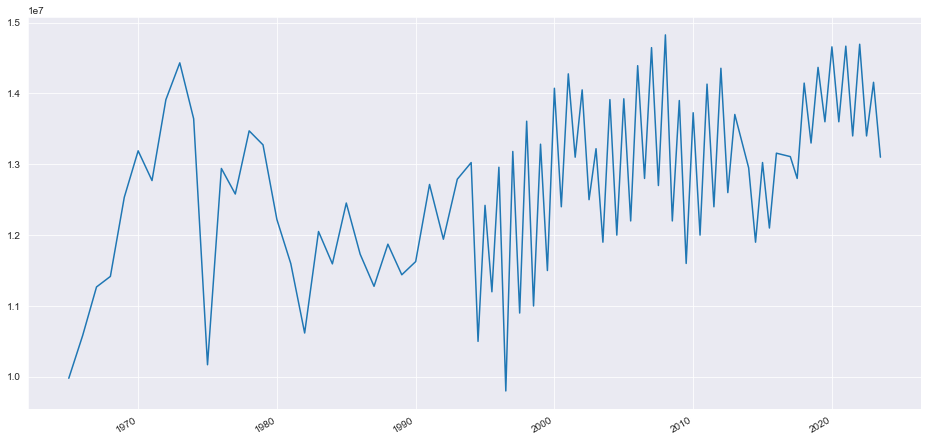

In [3]:
cattle_on_feed.plot()

<AxesSubplot:>

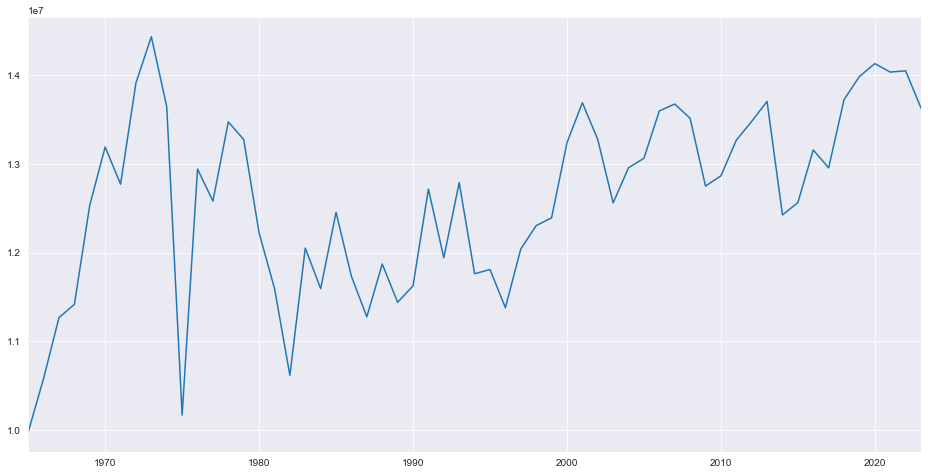

In [4]:
cattle_on_feed.resample('Y').mean().plot()

In [5]:
supply[supply.index.year==1982]

NameError: name 'supply' is not defined

- Supply for 1982 is reported quarterly rather than monthly, causing an anomaly
- Clean this by interpolating the missing monthly values from the quarterly values for 1982

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

anomaly_start_date = datetime(1982, 1, 1)
anomaly_end_date = datetime(1982, 12, 1)

current_date = anomaly_start_date
i = 0

supply_1982 = supply[supply.index.year == 1982]

supply_not_1982 = supply[supply.index.year!=1982]
supply_proportions = supply_not_1982.groupby(supply_not_1982.index.month).mean() / supply_not_1982.groupby(supply_not_1982.index.month).mean().sum()

while current_date <= anomaly_end_date:

    quarter = i // 3
    
    # Multiply the quarter's supply by the proportion for the current month
    val = supply_1982[quarter] * (supply_proportions[i+1]/ supply_proportions[quarter*3:(quarter+1)*3].sum())
    supply[current_date] = val
    
    current_date += relativedelta(months=1)
    i += 1


supply_pct_chg = supply.pct_change()*100
supply_pct_chg = supply_pct_chg.dropna()
supply_pct_chg.name = 'supply_pct_chg'

<AxesSubplot:xlabel='Date'>

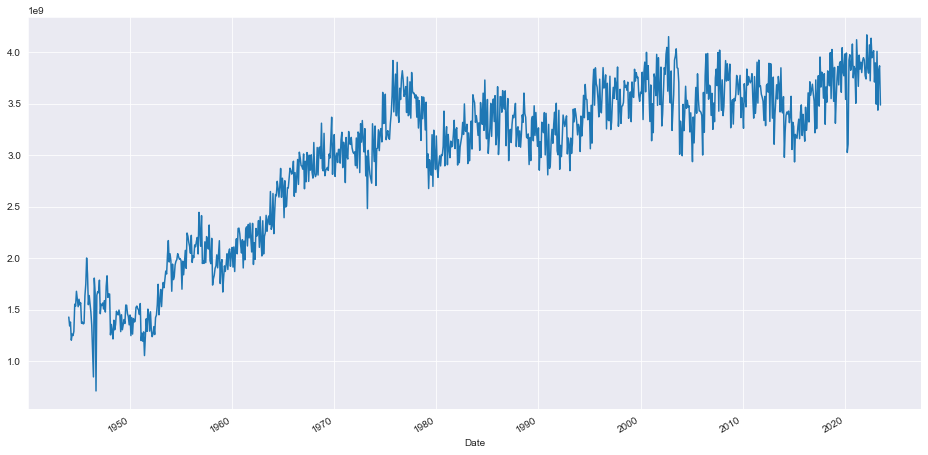

In [ ]:
supply.plot()

- Monthly slaughtered cattle live weight supply increased rapidly up to 1975, after which there is a much more moderate upward trend
    - Remove data before 1975 as from this period onwards the supply side has been more comparable, therefore better able to compare across years

In [ ]:
supply_pct_chg = supply_pct_chg[supply_pct_chg.index.year>=1975]

## Exploratory Analysis

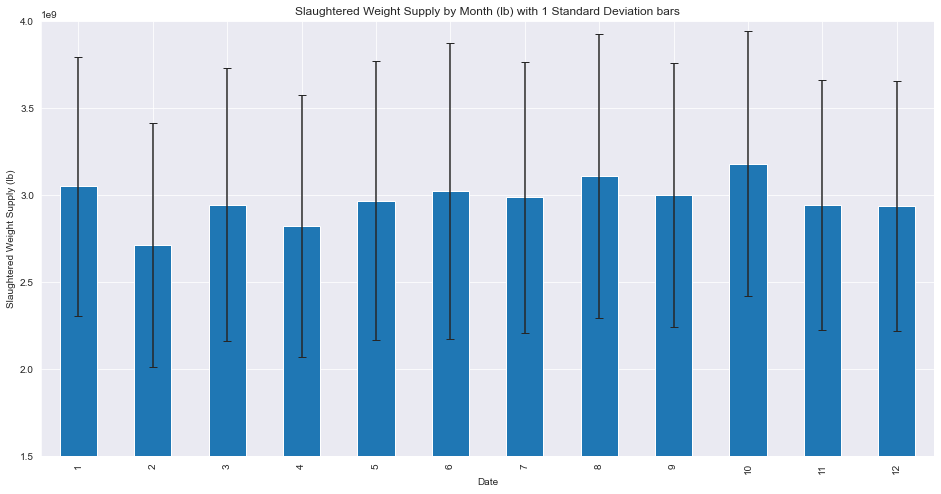

In [ ]:
mean_supply = supply.groupby(supply.index.month).mean()
std_supply = supply.groupby(supply.index.month).std()

ax = mean_supply.plot(kind='bar', yerr=std_supply, capsize=4)
ax.set_ylim([1500000000, 4000000000])
ax.set_ylabel('Slaughtered Weight Supply (lb)')

plt.title('Slaughtered Weight Supply by Month (lb) with 1 Standard Deviation bars')

plt.show()

Text(0, 0.5, 'Slaughtered Weight Supply (lb)')

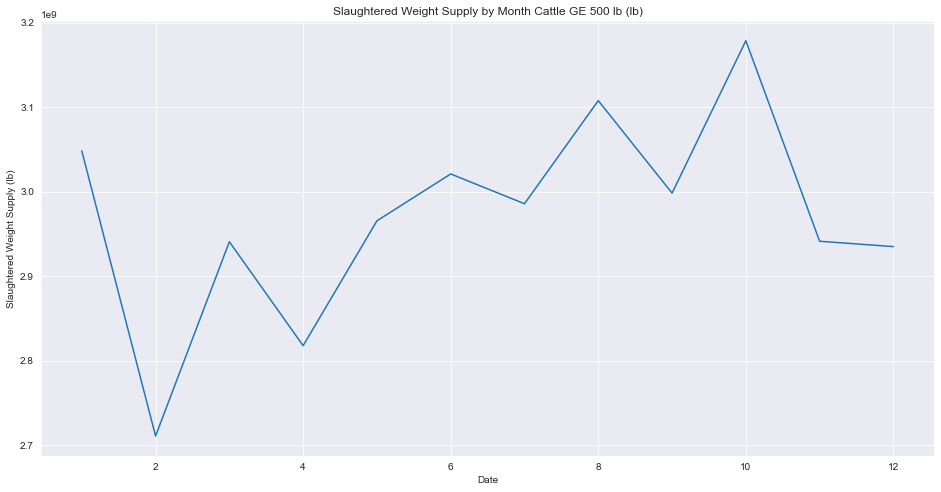

In [ ]:
supply.groupby(supply.index.month).mean().plot()
plt.title('ank')
plt.ylabel('Slaughtered Weight Supply (lb)')

In [ ]:
idx_min = mean_supply.idxmin()
idx_max = mean_supply.idxmax()
diff = round((mean_supply.max() - mean_supply.min())*100 / mean_supply.min(), 2)

print(f'Largest difference between mean supply occurs between months {idx_min} and {idx_max} with the max being {diff}% larger than the min')


Largest difference between mean supply occurs between months 2 and 10 with the max being 17.26% larger than the min


- February typically has the lowest supply and October has the highest
    - October supply is on average 17.26% higher than in February
    - No clear cyclical pattern as there is high price


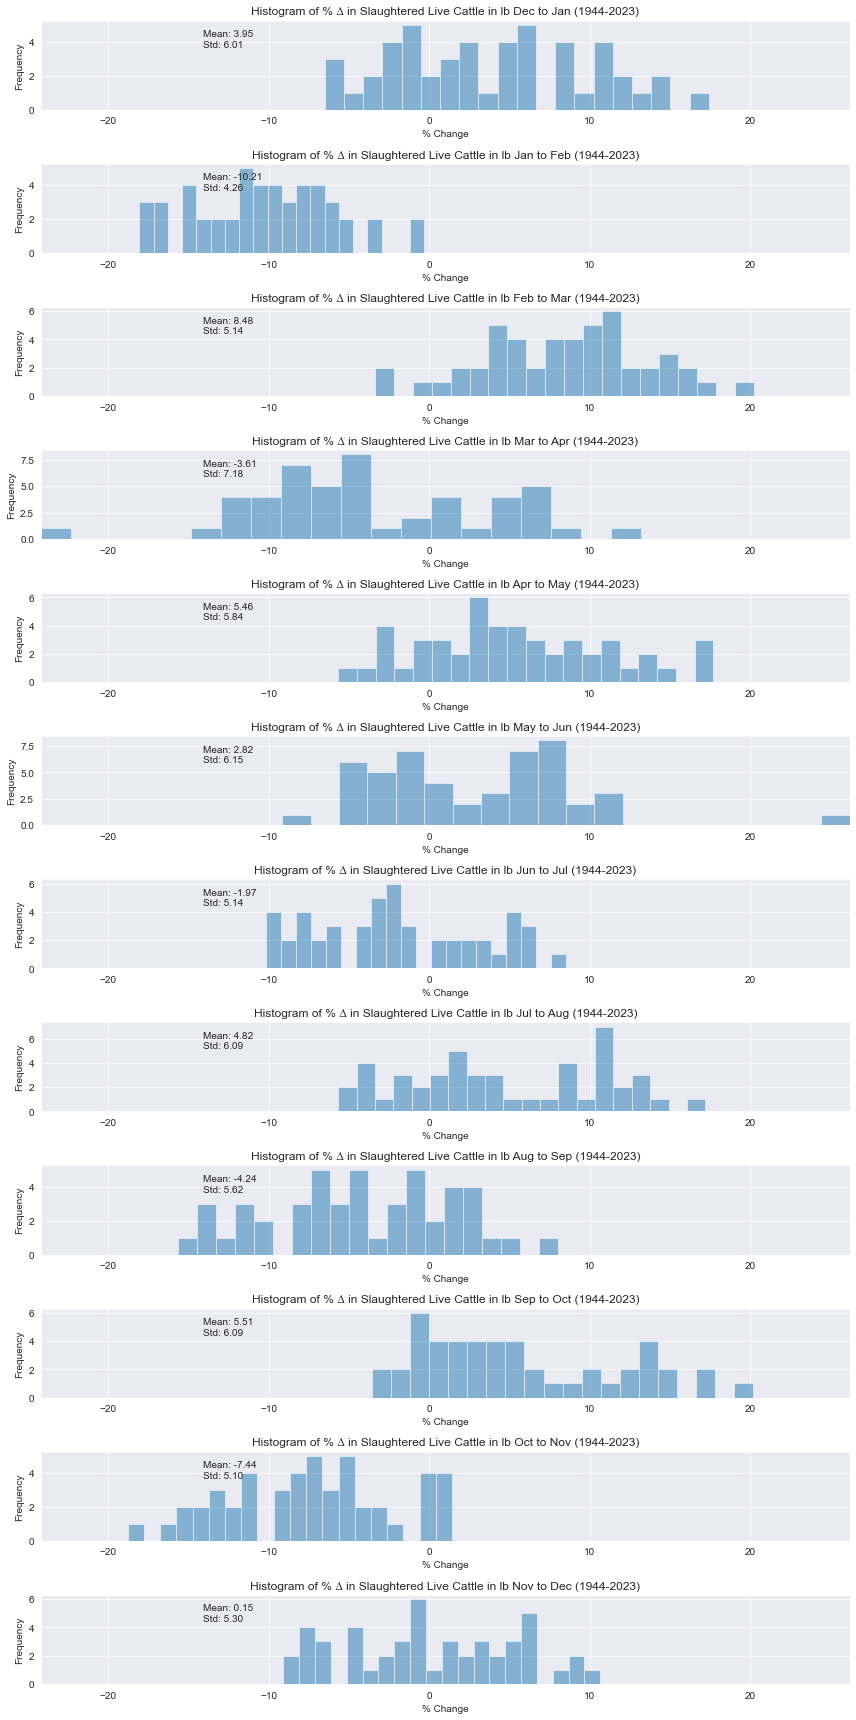

In [ ]:
look_back = 1

pct_change_lookback = supply_pct_chg
pct_change_group = supply_pct_chg.groupby(supply_pct_chg.index.month)

fig, axs = plt.subplots(nrows=12, figsize=(12, 24))

for i, (ax, pct_change_m) in enumerate(zip(axs, pct_change_group)):
    
    pct_change_m = pct_change_m[1].dropna()
    ax.hist(pct_change_m, bins=20, alpha=0.5)

    mu, std = np.mean(pct_change_m), np.std(pct_change_m)
    ax.text(0.2, 0.9, f"Mean: {mu:.2f}\nStd: {std:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_title(f'Histogram of % ∆ in Slaughtered Live Cattle in lb {src.number_to_month[(11+i)%12]} to {src.number_to_month[i]} (1944-2023)')
    ax.set_xlabel('% Change')
    ax.set_ylabel('Frequency')

    ax.set_xlim(pct_change_lookback.min(), pct_change_lookback.max())


plt.tight_layout()
plt.show()

- Althought there is no cyclical pattern in the slaughtered live cattle supply, the percentage changes across months have seasonality

In [ ]:
price_received_ge_500_national = pd.read_csv('../csv/price_received_ge_500_national.csv')
price_received_ge_500_national = src.usda_clean_monthly(price_received_ge_500_national, historical=True)
price_received_ge_500_national.name = 'price_received_ge_500_national'

price_received_ge_500_national_pct_chg = price_received_ge_500_national.pct_change()*100
price_received_ge_500_national_pct_chg.name = 'price_received_ge_500_national_pct_chg'
price_received_ge_500_national_pct_chg.dropna(inplace=True)

No handles with labels found to put in legend.


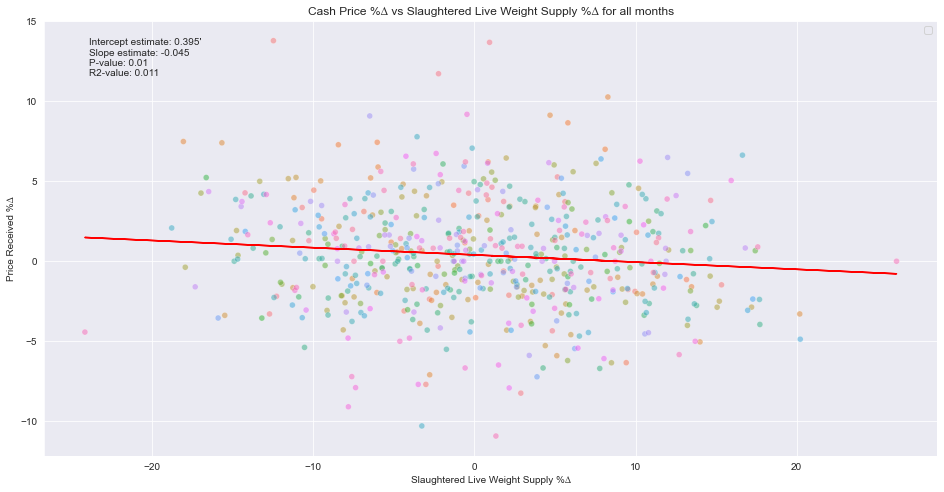

In [ ]:
src.scatterplot(
    price_received_ge_500_national_pct_chg,
    supply_pct_chg,
    'Price Received %∆',
    'Slaughtered Live Weight Supply %∆',
    reg=True,
    resample='M',
    title='Cash Price %∆ vs Slaughtered Live Weight Supply %∆ for all months',
)

In [ ]:
X_seasonal = pd.get_dummies(supply.index.month)
X_seasonal.index = supply.index
X_seasonal_supply = pd.concat([supply_pct_chg, X_seasonal], axis=1)
X_seasonal_supply = sm.add_constant(X_seasonal_supply)
X_seasonal_supply = X_seasonal_supply.dropna()

X = X_seasonal_supply

y = price_received_ge_500_national_pct_chg
y.name = 'price_received_ge_500_national_pct_chg'

intersection_index = y.index.intersection(X.index)
intersection_index

y = y[intersection_index]
X = X.loc[intersection_index]


model = sm.OLS(y, X).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.128
Model:                                                OLS   Adj. R-squared:                  0.110
Method:                                     Least Squares   F-statistic:                     6.959
Date:                                    Tue, 12 Sep 2023   Prob (F-statistic):           7.65e-12
Time:                                            23:33:38   Log-Likelihood:                -1495.5
No. Observations:                                     582   AIC:                             3017.
Df Residuals:                                         569   BIC:                             3074.
Df Model:                                              12                                         
Covariance Type:                                nonrobust                                         
          

In [ ]:
X_seasonal_supply_monthly = pd.get_dummies(supply.index.month)
X_seasonal_supply_monthly.index = supply.index

for month in range(1, 13):
    X_seasonal_supply_monthly[f'supply_pct_chg*month_{month}'] = X_seasonal_supply_monthly[month] * supply_pct_chg


X_seasonal_supply_monthly = sm.add_constant(X_seasonal_supply_monthly)
X_seasonal_supply_monthly = X_seasonal_supply_monthly.dropna()

X = X_seasonal_supply_monthly

y = price_received_ge_500_national_pct_chg


intersection_index = y.index.intersection(X.index)
intersection_index

y = y[intersection_index]
X = X.loc[intersection_index]



model = sm.OLS(y, X).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.147
Model:                                                OLS   Adj. R-squared:                  0.112
Method:                                     Least Squares   F-statistic:                     4.171
Date:                                    Tue, 12 Sep 2023   Prob (F-statistic):           6.69e-10
Time:                                            23:33:38   Log-Likelihood:                -1489.1
No. Observations:                                     582   AIC:                             3026.
Df Residuals:                                         558   BIC:                             3131.
Df Model:                                              23                                         
Covariance Type:                                nonrobust                                         
          